<a href="https://colab.research.google.com/github/rallyfranky/my-first-repo/blob/main/%E6%95%B0%E7%90%86%E6%9C%80%E9%81%A9%E5%8C%96_S4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PulP
import pulp
import pandas as pd
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.3 MB 8.6 MB/s 


EDA

In [2]:
cust_df = pd.read_csv('/content/drive/MyDrive/4.coupon/customers.csv')

In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  5000 non-null   int64 
 1   age_cat      5000 non-null   object
 2   freq_cat     5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [4]:
cust_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


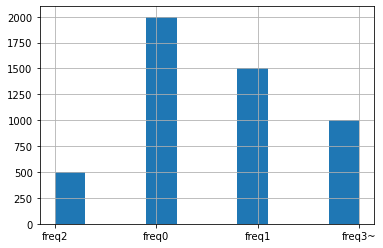

In [5]:
import matplotlib.pyplot as plt

cust_df['freq_cat'].hist()

In [6]:
cust_pivot_df = pd.pivot_table(data=cust_df,
               columns='freq_cat',
               index='age_cat',
               values='customer_id',
               aggfunc='count')
cust_pivot_df = cust_pivot_df.reindex(['age~19','age20~34','age35~49','age50~'])
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


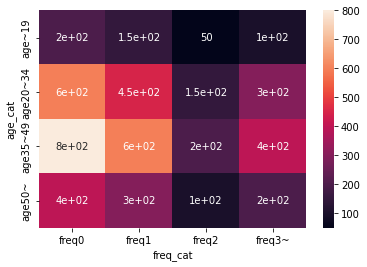

In [7]:
sns.heatmap(cust_pivot_df, annot=True)

In [8]:
prob_df = pd.read_csv('/content/drive/MyDrive/4.coupon/visit_probability.csv')
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


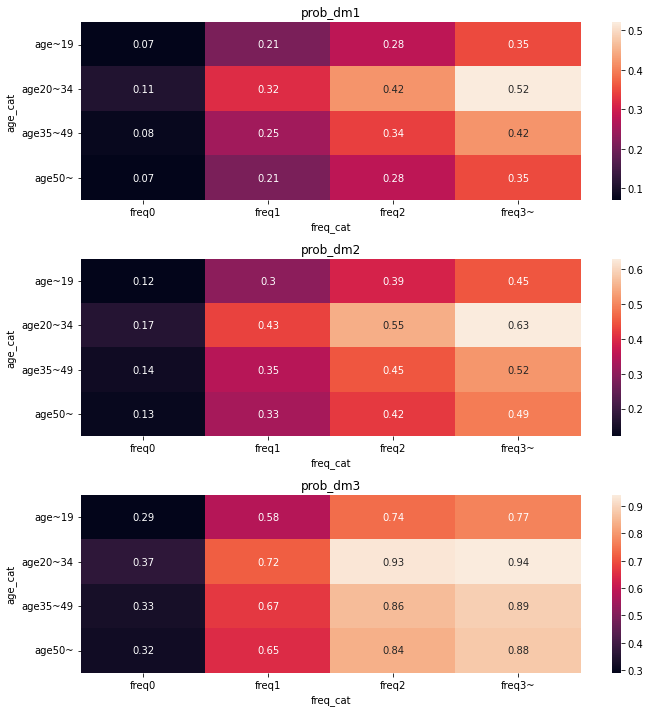

In [9]:

fig = plt.figure(figsize=(10,10))
list = ['prob_dm1','prob_dm2','prob_dm3']

for i in range(len(list)):
  plt.subplot(len(list),1,i+1)
  prof_pivot = pd.pivot_table(
      data=prob_df,
      columns='freq_cat',
      index='age_cat',
      values=list[i],
      aggfunc='mean'
  )
  prof_pivot=prof_pivot.reindex(['age~19','age20~34','age35~49','age50~'])
  sns.heatmap(prof_pivot,annot=True)
  plt.title(list[i])

plt.tight_layout()

## ***数理最適化***

会員個別送付モデル

In [11]:
'''
パターン別に来店率が最大となる配信パターンを実装する
会員別に0か1かを決定して全体の効果を最大化する。
'''


problem = pulp.LpProblem(name='coupon_problem',sense=pulp.LpMaximize)

In [25]:
#リスト作成
I = cust_df['customer_id'].to_list()
#メールパターンリスト
M = [1, 2, 3]
#セグメントリスト
S = prob_df['segment_id'].tolist()
#セグメント別ユーザ数
keys = ['age_cat', 'freq_cat']
cust_prob_df = pd.merge(cust_df, prob_df, on=keys)
Ns = cust_prob_df.groupby('segment_id')['customer_id'].count().to_dict()
print(Ns)

{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [26]:
#決定変数
xsm={}
for s in S:
  for m in M:
    xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})',
                             lowBound=0,
                             upBound=1,
                             cat='Continuous')
len(xsm)

48

In [27]:
#各自いずれか1カテゴリ
for s in S:
  problem += pulp.lpSum(xsm[s,m] for m in M) == 1

In [28]:
#クーポンによる来店増加期待値
prob_ver_df = prob_df.rename(columns={'prob_dm1': 1,'prob_dm2': 2, 'prob_dm3': 3})\
.melt(id_vars=['segment_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
Psm = prob_ver_df.set_index(['segment_id','dm'])['prob'].to_dict()

In [29]:
#目的関数、来店増加数
problem += pulp.lpSum(Ns[s]*(Psm[s,m]-Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])